In [17]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
!python -V

Python 3.9.20


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error



In [29]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")

mlflow.set_experiment("nyc-taxi-experiment_2")



<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/4', creation_time=1733506662911, experiment_id='4', last_update_time=1733506662911, lifecycle_stage='active', name='nyc-taxi-experiment_2', tags={}>

In [21]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60 )
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    
    df[categorical] = df[categorical].astype(str)
    
    return df

In [22]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [23]:
len(df_train), len(df_val)

(73908, 61921)

In [24]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [25]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(7.758715208009878)

In [97]:
lr = Ridge()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.342603943214286

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


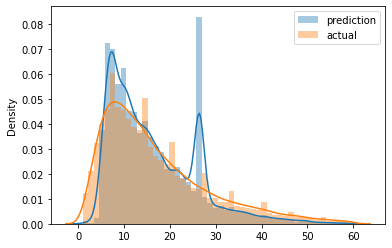

In [108]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [27]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out) #guardamos el diccionario vectorizado y el modelo

In [ ]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "javier")
    
    mlflow.log_param("train-data-path", "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "data/green_tripdata_2021-02.parquet")    
    
    
    alpha= 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train,y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(models)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3), exp(0) - [0,05 -1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:43:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.66249                          
[1]	validation-rmse:11.15942                          
[2]	validation-rmse:10.70070                          
[3]	validation-rmse:10.28375                          
[4]	validation-rmse:9.90437                           
[5]	validation-rmse:9.56065                           
[6]	validation-rmse:9.24980                           
[7]	validation-rmse:8.96731                           
[8]	validation-rmse:8.71311                           
[9]	validation-rmse:8.48444                           
[10]	validation-rmse:8.27877                          
[11]	validation-rmse:8.09373                          
[12]	validation-rmse:7.92752                          
[13]	validation-rmse:7.77871                          
[14]	validation-rmse:7.64574                          
[15]	validation-rmse:7.52683                          
[16]	validation-rmse:7.41950                          
[17]	validation-rmse:7.32390                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:49:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02518                                                      
[1]	validation-rmse:10.07273                                                      
[2]	validation-rmse:9.31526                                                       
[3]	validation-rmse:8.71793                                                       
[4]	validation-rmse:8.25151                                                       
[5]	validation-rmse:7.89015                                                       
[6]	validation-rmse:7.61235                                                       
[7]	validation-rmse:7.39745                                                       
[8]	validation-rmse:7.23176                                                       
[9]	validation-rmse:7.10502                                                       
[10]	validation-rmse:7.00570                                                      
[11]	validation-rmse:6.92883                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:52:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.91709                                                       
[1]	validation-rmse:8.52319                                                       
[2]	validation-rmse:7.71266                                                       
[3]	validation-rmse:7.25174                                                       
[4]	validation-rmse:6.99039                                                       
[5]	validation-rmse:6.83334                                                       
[6]	validation-rmse:6.73897                                                       
[7]	validation-rmse:6.67741                                                       
[8]	validation-rmse:6.63964                                                       
[9]	validation-rmse:6.61297                                                       
[10]	validation-rmse:6.59472                                                      
[11]	validation-rmse:6.58228                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:54:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.62566                                                       
[1]	validation-rmse:8.17021                                                       
[2]	validation-rmse:7.39145                                                       
[3]	validation-rmse:6.98166                                                       
[4]	validation-rmse:6.76627                                                       
[5]	validation-rmse:6.65103                                                       
[6]	validation-rmse:6.58369                                                       
[7]	validation-rmse:6.53800                                                       
[8]	validation-rmse:6.51057                                                       
[9]	validation-rmse:6.49267                                                       
[10]	validation-rmse:6.48031                                                      
[11]	validation-rmse:6.47263                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:55:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55427                                                        
[1]	validation-rmse:8.11740                                                        
[2]	validation-rmse:7.36554                                                        
[3]	validation-rmse:6.99164                                                        
[4]	validation-rmse:6.81772                                                        
[5]	validation-rmse:6.69566                                                        
[6]	validation-rmse:6.63427                                                        
[7]	validation-rmse:6.59564                                                        
[8]	validation-rmse:6.57371                                                        
[9]	validation-rmse:6.56147                                                        
[10]	validation-rmse:6.55389                                                       
[11]	validation-rmse:6.54453                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:57:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.90433                                                        
[1]	validation-rmse:6.77791                                                        
[2]	validation-rmse:6.75792                                                        
[3]	validation-rmse:6.74230                                                        
[4]	validation-rmse:6.74281                                                        
[5]	validation-rmse:6.73887                                                        
[6]	validation-rmse:6.73612                                                        
[7]	validation-rmse:6.73239                                                        
[8]	validation-rmse:6.72948                                                        
[9]	validation-rmse:6.72175                                                        
[10]	validation-rmse:6.71429                                                       
[11]	validation-rmse:6.71660                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:58:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75815                                                       
[1]	validation-rmse:11.33715                                                       
[2]	validation-rmse:10.94810                                                       
[3]	validation-rmse:10.58895                                                       
[4]	validation-rmse:10.25790                                                       
[5]	validation-rmse:9.95327                                                        
[6]	validation-rmse:9.67302                                                        
[7]	validation-rmse:9.41564                                                        
[8]	validation-rmse:9.17984                                                        
[9]	validation-rmse:8.96375                                                        
[10]	validation-rmse:8.76607                                                       
[11]	validation-rmse:8.58538                                                

KeyboardInterrupt: 